In [1]:
modelPath = "Clickbait"
checkpoint = "microsoft/Multilingual-MiniLM-L12-H384"
                                              # "cmarkea/distilcamembert-base-sentiment"
                                              # "cmarkea/distilcamembert-base" (accuracy=0,69)
                                              # "camembert-base"
                                              # "microsoft/Multilingual-MiniLM-L12-H384" (accuracy=0,64)
                                              # "nlptown/bert-base-multilingual-uncased-sentiment"
                                              # "distilbert-base-uncased-finetuned-sst-2-english"
                                              # "bert-base-uncased"
problem_type =  "regression" # Valeurs possibles : "regression", "single_label_classification", "multi_label_classification"
num_labels = 1                                # 5
dataCuratedPath = "Data/Curated"              # Données pour tous les sites du 1er janvier 2021 au 30 avril 2021
                                              # Données juste pour le site "Actualités, trucs et astuces" entre le 1er mai et le 31 juillet 2021.
                                              # Les colonnes sont les suivantes, séparées par des ";" :
                                              #    Page name;Title;Publish time;People Reached;Link Clicks
LCfraction = 'truthMean'
inputColumn = 'postText'
removeColumns = ['postText', 'targetTitle', 'targetDescription', 'id', 'truthMean'] # Il faut enlever les colonnes de type texte
splitFactor = 0.2                             # Proportion de données réservées pour les tests
push_to_hub = False
learning_rate = 5e-5
weight_decay=0.01

In [2]:
import torch
import numpy as np

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
   checkpoint,
   problem_type=problem_type,
   num_labels = num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
print(tokenizer("Bonjour, comment ça va ?"))
print(tokenizer.tokenize("Hello, how are you?"))
print(tokenizer.encode("Bonjour, comment ça va ?"))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("Bonjour, comment ça va ?")))
print(tokenizer.convert_ids_to_tokens(tokenizer.encode("Bonjour, comment ça va ?")))
print(tokenizer.decode(tokenizer.encode("Bonjour, comment ça va ?")))

{'input_ids': [0, 84602, 4, 6868, 3244, 307, 705, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
['▁Hello', ',', '▁how', '▁are', '▁you', '?']
[0, 84602, 4, 6868, 3244, 307, 705, 2]
[84602, 4, 6868, 3244, 307, 705]
['<s>', '▁Bonjour', ',', '▁comment', '▁ça', '▁va', '▁?', '</s>']
<s> Bonjour, comment ça va?</s>


In [5]:
import datasets as ds

In [6]:
curated = ds.load_from_disk(dataCuratedPath)

In [7]:
curated.to_pandas()

,postText,targetTitle,targetDescription,truthMean,id
0,"Panama Papers: Europol links 3,500 names to su...","Panama Papers: Europol links 3,500 names to su...",Law enforcement agency analysis uncovers proba...,0.066667,804113781580328960
1,The key to truly great chicken soup,A Superior Chicken Soup,For the best rendition of this American classi...,0.733333,804119512010424320
2,Afghan policewomen face down their fears to serve,100 Women 2016: On the frontline with the wome...,The Afghan women risking all to join the police.,0.333333,804121272967983104
3,Conservatives are watching less football this ...,Older Viewers and Conservatives Are Watching L...,"Many factors are dragging down NFL ratings, in...",0.066667,804123103995580416
4,Richard Sherman weighs in on Cam Newton’s stru...,Seattle Seahawks Richard Sherman Says 'Karma' ...,"Seattle Seahawks news, rumors, scores, schedul...",0.133333,804126501117435904
...,...,...,...,...,...
19533,Trump now agrees with the majority of American...,Donald Trump said being US president was harde...,Donald Trump spent a great portion of 2016 ins...,0.000000,858455355948384257
19534,Trump has flip-flopped. But his supporters are...,Trump Has Flip-Flopped. But His Supporters Are...,Barely over a tenth of Trump voters think his ...,0.266667,858459539296980995
19535,Inside North Korea's secret prisons,Inside Kim Jong-un's camps of death: Former No...,A female guard (stock photo) at a North Korean...,0.400000,858460992073863168
19536,UK’s response to modern slavery leaving victim...,‘Inexcusable’ failures in UK’s response to mod...,“Inexcusable” failures in the UK’s system for ...,0.133333,858462320779026433


In [8]:
longueur= len(curated)
longueur

19538

In [9]:
trie=sorted(curated[LCfraction])

In [10]:
import matplotlib.pyplot as plt

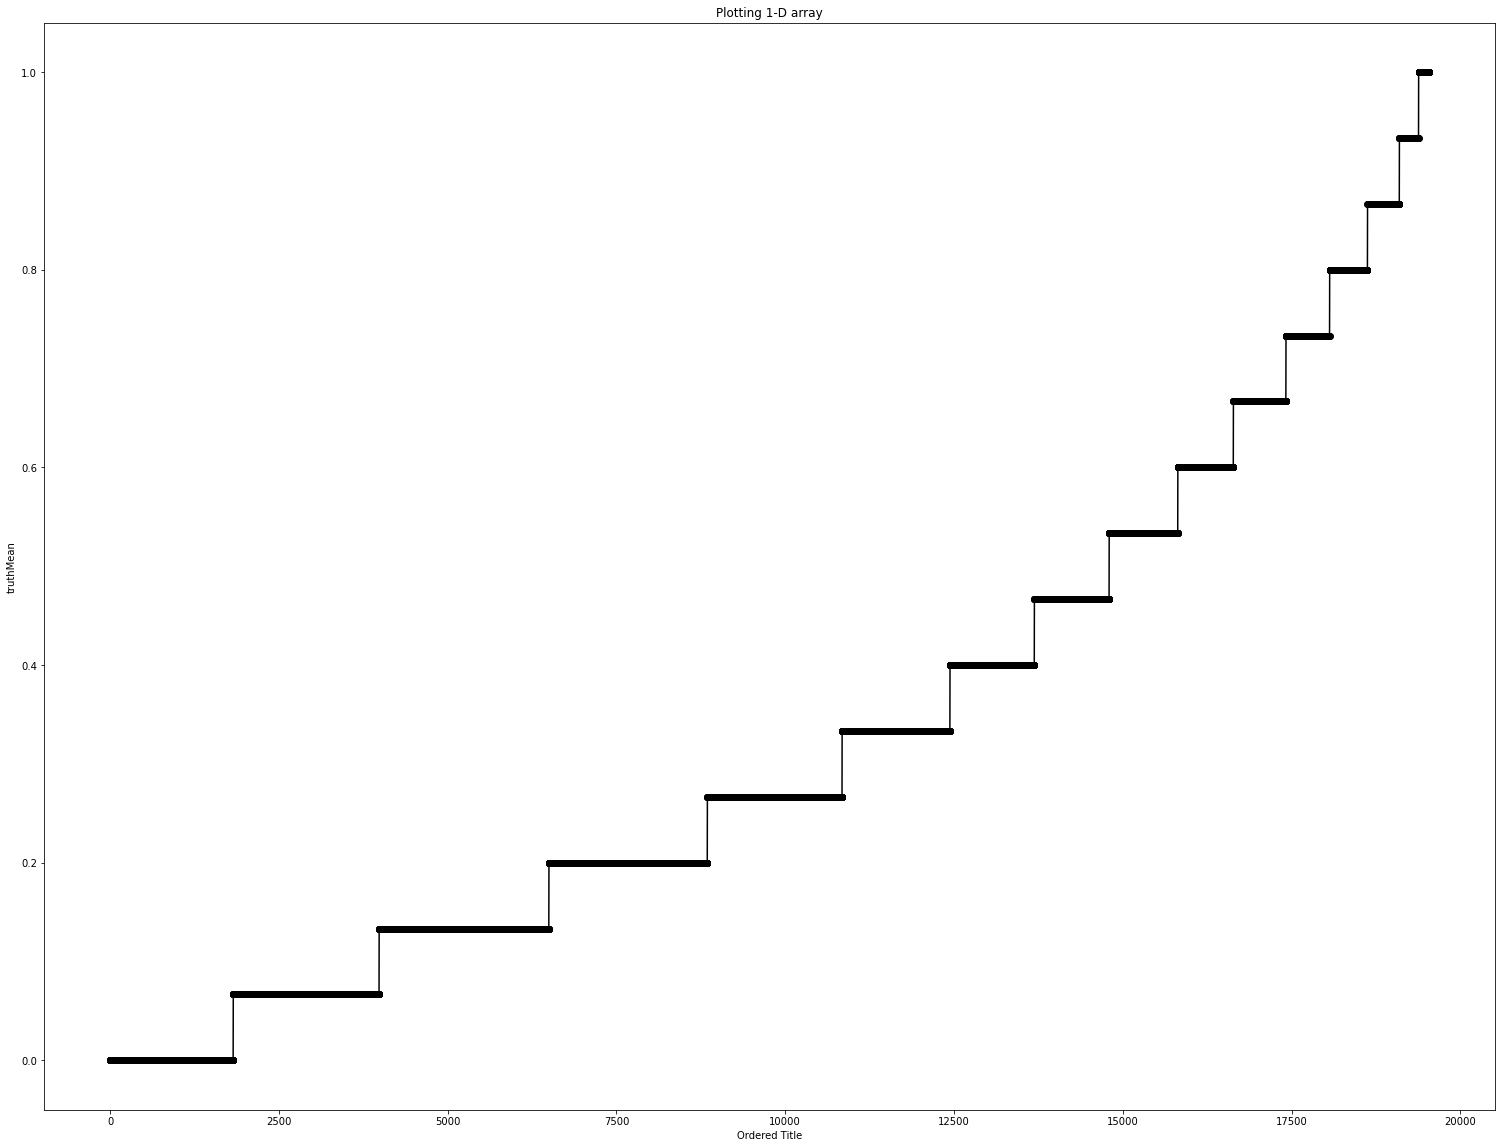

In [11]:
plt.figure(figsize=(26, 20))
plt.title("Plotting 1-D array")
plt.xlabel("Ordered Title")
plt.ylabel(LCfraction)
x = np.array(range(0, longueur))
y = np.array(trie)
plt.plot(x, y, color = "black", marker = "o", label = "Array elements")

In [12]:
ncf=[None] * (num_labels-1)
for i in range(num_labels-1):
    ncf[i] = trie[longueur * (i+1) // num_labels]
ncf

[]

In [13]:
def tokenize(sample):
    tokenized_sample = tokenizer(
            sample[inputColumn],   #  postText + ". Paru dans " + sample["Page name"], #+ ", le " + sample["Publish time"]
            # str(int(sample[LCfraction]*100)), # on donne direct le résultat pour voir si accuracy == 1
            #padding=True,
            #truncation=True,
            #max_length=30
            )

    fraction = sample[LCfraction]
    
    if num_labels == 1:
        tokenized_sample["labels"] = fraction
    else:
        tokenized_sample["labels"] = next((x for x, val in enumerate(ncf) if fraction < val), num_labels-1)
    
    
    # print( fraction, tokenized_sample["input_ids"], tokenized_sample["label"], sample[inputColumn])
    
    return tokenized_sample

In [14]:
tokenized_curated = curated.map(tokenize) #, batched=True)

Loading cached processed dataset at Data/Curated\cache-08773887acc0b364.arrow


In [15]:
tokenized_curated

Dataset({
    features: ['postText', 'targetTitle', 'targetDescription', 'truthMean', 'id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 19538
})

In [16]:
tokenized_curated.to_pandas().describe()

,truthMean,labels
count,19538.000000,19538.000000
mean,0.324530,0.324530
std,0.252824,0.252824
min,0.000000,0.000000
25%,0.133333,0.133333
50%,0.266667,0.266667
75%,0.466667,0.466667
max,1.000000,1.000000


In [17]:
print(tokenized_curated[0:3])

{'postText': ['Panama Papers: Europol links 3,500 names to suspected criminals', 'The key to truly great chicken soup', 'Afghan policewomen face down their fears to serve'], 'targetTitle': ['Panama Papers: Europol links 3,500 names to suspected criminals', 'A Superior Chicken Soup ', '100 Women 2016: On the frontline with the women policing the peace in Afghanistan'], 'targetDescription': ['Law enforcement agency analysis uncovers probable matches connected to terrorism, money laundering and organised crime', 'For the best rendition of this American classic, start with a whole bird.', 'The Afghan women risking all to join the police.'], 'truthMean': [0.06666666666, 0.73333333332, 0.33333333330000003], 'id': ['804113781580328960', '804119512010424320', '804121272967983104'], 'input_ids': [[0, 149674, 62323, 7, 12, 3939, 5877, 22317, 138, 4, 4283, 123055, 47, 92610, 297, 49602, 7, 2], [0, 581, 22799, 47, 87607, 6782, 143896, 101084, 2], [0, 57351, 1121, 35206, 3613, 1055, 2577, 7565, 236

In [18]:
tokenized_curated2 = tokenized_curated.train_test_split(splitFactor) # 0.2

In [19]:
tokenized_curated2['train'].to_pandas()

,postText,targetTitle,targetDescription,truthMean,id,input_ids,attention_mask,labels
0,16 year old sets new world record by breaking ...,European Taekwondo Champ Sets New World Record...,"First, you must fill your head with knowledge....",0.333333,846471430774546432,"[0, 611, 6602, 10332, 5423, 7, 3525, 8999, 171...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.333333
1,UK to hold 'biggest protest ever' for Donald T...,Donald Trump: London to hold 'biggest protest ...,Campaigners are urging people to stage “the bi...,0.133333,825702795437305856,"[0, 17274, 47, 16401, 242, 32976, 177, 525, 18...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.133333
2,Jackie Evancho's music sales boom after announ...,Jackie Evancho's music sales boom after announ...,While some singers have pulled out of performi...,0.133333,813911972202868736,"[0, 187792, 107904, 3089, 25, 7, 19612, 40575,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333
3,at long last.,NYT Calls for Transgender Education in Emergen...,The New York Times published an article titled...,0.600000,853289924782673920,"[0, 99, 4989, 4568, 5, 2]","[1, 1, 1, 1, 1, 1]",0.600000
4,Kentucky ranked worst state for animal safety ...,Kentucky ranked worst state for animal safety ...,A comprehensive review of animal safety laws t...,0.266667,819190398128128000,"[0, 229879, 30648, 297, 130481, 11341, 100, 26...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.266667
...,...,...,...,...,...,...,...,...
15625,"Kylie Jenner remembers she's 19, crashes high ...","Kylie Jenner Remembers She's 19, Crashes High ...","Somewhere, a prom queen is FUMING.",0.266667,851466797341691905,"[0, 90982, 478, 845, 13857, 37629, 7, 2412, 25...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.266667
15626,"Rajon Rondo was fined $25,000 for trying to tr...",Rajon Rondo Fined $25K for Tripping Jae Crowde...,Chicago Bulls guard Rajon Rondo was fined $...,0.000000,856187417556115456,"[0, 16930, 191, 2777, 557, 509, 5885, 71, 7879...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000000
15627,🆘 This guy got high with his grandma and they ...,Dude Gets Blazed With His Grandma for the Firs...,Tip for everyone: Get high with your grandpare...,0.400000,849329669522501633,"[0, 6, 247402, 3293, 48948, 4163, 11192, 678, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.400000
15628,"The 6 yr old boy, injured when a six off #Sure...",Despite Getting Hit By A Six From Suresh Raina...,India beat England by 75 runs to win the 3-mat...,0.200000,827076619663704064,"[0, 581, 305, 2938, 10332, 25299, 4, 23, 461, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000


In [20]:
tokenized_curated3 = tokenized_curated2.remove_columns(removeColumns)

In [21]:
tokenized_curated4 = tokenized_curated3

In [22]:
tokenized_curated4

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 15630
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3908
    })
})

In [23]:
# tokenized_curated4.set_format("torch")

In [24]:
from datasets import load_metric
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    if num_labels == 1:
        metric = load_metric("mse")
        return metric.compute(predictions=logits, references=labels)
    elif num_labels == 2:
        predictions = np.argmax(logits, axis=-1)
        accuracy = accuracy_score(y_true=labels, y_pred=predictions)
#    recall = recall_score(y_true=labels, y_pred=predictions)
#    precision = precision_score(y_true=labels, y_pred=predictions)
        f1 = f1_score(y_true=labels, y_pred=predictions)
    # return metric.compute(predictions=predictions, references=labels) # , average = 'weighted'
        return {"accuracy": accuracy, "f1": f1 } #" "matthews_correlation":matthews_correlation precision": precision, "recall": recall, "f1": f1, 
    else:
        predictions = np.argmax(logits, axis=-1)
        metric = load_metric("matthews_correlation") # matthews_correlation, accuracy "glue", "mrpc") # , "sst2") #  stsb de la ouatte de phoque
        matthews_correlation = metric.compute(predictions=predictions, references=labels)
        # accuracy = accuracy_score(y_true=labels, y_pred=predictions)
        # f1 = f1_score(y_true=labels, y_pred=predictions)
        return matthews_correlation
        # return {"accuracy": accuracy}.update(matthews_correlation)

In [25]:
from transformers import TrainingArguments

training_args = TrainingArguments(modelPath,
                                  evaluation_strategy= "steps", # "epoch",
                                  eval_steps = 50, # Evaluation and Save happens every 50 steps
                                  save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.
                                  num_train_epochs = 4,
                                  optim= 'adamw_torch',
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size = 16,
                                  per_device_eval_batch_size = 16,
                                  # learning_rate = 5e-4,
                                  weight_decay=weight_decay,
                                  push_to_hub=push_to_hub,
                                  metric_for_best_model = 'accuracy' if num_labels == 2 else 'mse' if num_labels == 1 else 'matthews_correlation',
                                  load_best_model_at_end=True
                                 )

In [26]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer)

In [27]:
print(tokenized_curated4["train"][0:20])

{'input_ids': [[0, 611, 6602, 10332, 5423, 7, 3525, 8999, 17164, 390, 116987, 36682, 46389, 7, 23, 2273, 94131, 27, 76228, 1919, 10336, 6, 246135, 12, 2], [0, 17274, 47, 16401, 242, 32976, 177, 525, 18782, 17669, 25, 100, 16692, 5879, 19922, 2], [0, 187792, 107904, 3089, 25, 7, 19612, 40575, 77227, 7103, 8668, 34, 60636, 33428, 1363, 23718, 2], [0, 99, 4989, 4568, 5, 2], [0, 229879, 30648, 297, 130481, 11341, 100, 26249, 81900, 100, 209, 927, 148390, 13, 6602, 2], [0, 601, 10931, 707, 6, 132824, 32, 2], [0, 581, 1820, 14865, 4432, 41550, 18813, 25, 7, 80560, 9, 2037, 208984, 89406, 2], [0, 8254, 14, 9615, 19929, 7, 12, 4865, 442, 25, 7, 1884, 47, 6867, 46132, 10, 101637, 71, 3551, 2], [0, 22576, 9, 114686, 1314, 138804, 137107, 100, 7003, 4588, 120631, 316, 1957, 1728, 52875, 297, 23, 24727, 53, 4445, 2], [0, 15497, 10013, 3398, 85018, 51065, 44, 4332, 137089, 6436, 58, 9742, 112474, 2], [0, 58823, 44, 1462, 41039, 6635, 106820, 58, 2412, 1277, 1314, 177705, 7, 4, 28927, 90, 35463, 116

In [28]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

trainer = Trainer(model,
                  training_args,
                  train_dataset=tokenized_curated4["train"],
                  eval_dataset=tokenized_curated4["test"],
                  data_collator=data_collator,
                  tokenizer=tokenizer,
                  compute_metrics = compute_metrics,
                  callbacks = [EarlyStoppingCallback(early_stopping_patience=3)], #3
                  # optimizers=(torch.optim.AdamW, torch.optim.lr_scheduler.LambdaLR) 
                 )

In [29]:
# faire la boucle avec le trainer pytorch
# %pdb
trainer.train()

***** Running training *****
  Num examples = 15630
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3908


Step,Training Loss,Validation Loss,Mse
50,No log,0.049501,0.049501
100,No log,0.032442,0.032442
150,No log,0.038331,0.038331
200,No log,0.030546,0.030546
250,No log,0.035531,0.035531
300,No log,0.028582,0.028582
350,No log,0.029796,0.029796
400,No log,0.030137,0.030137
450,No log,0.029839,0.029839
500,0.036000,0.026713,0.026713


***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
Saving model checkpoint to Clickbait\checkpoint-500
Configuration saved in Clickbait\checkpoint-500\config.json
Model weights saved in Clickbait\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Clickbait\checkpoint-500\tokenizer_config.json
Special tokens file saved in Click

TrainOutput(global_step=1200, training_loss=0.03079957127571106, metrics={'train_runtime': 249.7409, 'train_samples_per_second': 250.339, 'train_steps_per_second': 15.648, 'total_flos': 76865405727432.0, 'train_loss': 0.03079957127571106, 'epoch': 1.23})

In [30]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16


{'eval_loss': 0.026713242754340172,
 'eval_mse': 0.026713244442976108,
 'eval_runtime': 5.5206,
 'eval_samples_per_second': 707.89,
 'eval_steps_per_second': 44.379,
 'epoch': 1.23}

In [31]:
# Sauver le modèle sur le disque
model.save_pretrained(modelPath)

Configuration saved in Clickbait\config.json
Model weights saved in Clickbait\pytorch_model.bin


In [32]:
tokenizer.save_vocabulary(modelPath)

('Clickbait\\sentencepiece.bpe.model',)

In [33]:
# Pour voir si on fait de l'overfitting, rien de mieux que de dessiner le graphe avec le jeu d'entrainement
overfitting = "test" #  "train" # "test"

In [34]:
model.to(torch.device("cuda:0"))
predictions = trainer.predict(tokenized_curated4[overfitting])

***** Running Prediction *****
  Num examples = 3908
  Batch size = 16


In [35]:
predictions.predictions

array([[0.2291893 ],
       [0.16803335],
       [0.1636244 ],
       ...,
       [0.6951629 ],
       [0.18062982],
       [0.65716434]], dtype=float32)

In [36]:
predictions.metrics

{'test_loss': 0.026713242754340172,
 'test_mse': 0.026713244442976108,
 'test_runtime': 7.453,
 'test_samples_per_second': 524.353,
 'test_steps_per_second': 32.873}

In [37]:
tct = tokenized_curated2[overfitting].to_pandas()

In [38]:
if num_labels == 1:
    tct["labelC"] = predictions.predictions
else:
    tct["labelC"] = np.argmax(predictions.predictions, axis=1)   

In [39]:
tct = tct.sort_values(LCfraction)

In [40]:
palette = ["r", "g", "b", "c", "m"]

In [41]:
if num_labels == 1:
    color = [val for val in tct["labelC"]]
else:
    color = [palette[val] for val in tct["labelC"]]

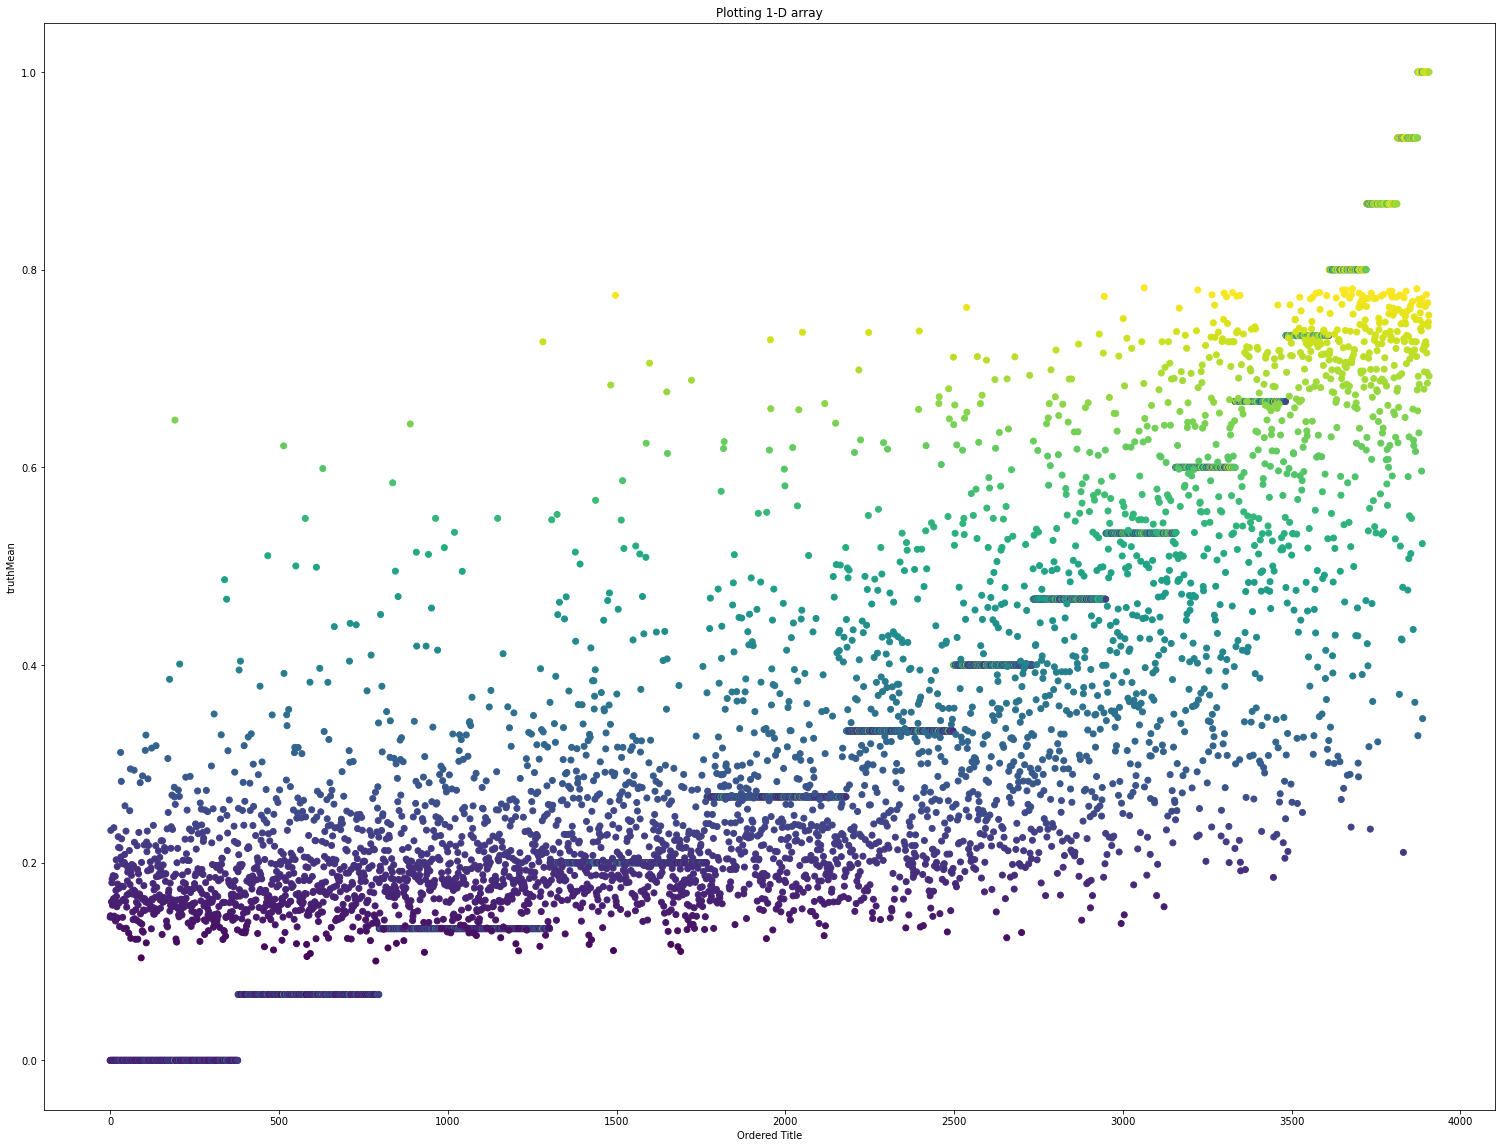

In [42]:
plt.figure(figsize=(26, 20))
plt.title("Plotting 1-D array")
plt.xlabel("Ordered Title")
plt.ylabel(LCfraction) #LCfraction
x = np.array(range(0, tct.shape[0]))
y = tct[LCfraction]
plt.scatter(x, y, c = color, marker = "o", label = "Array elements")
y2= tct["labelC"]
plt.scatter(x, color, c = color, marker = "o", label = "Array elements")

In [43]:
tct

,postText,targetTitle,targetDescription,truthMean,id,input_ids,attention_mask,labels,labelC
1973,Jeff Fisher ties Dan Reeves for most losses in...,Los Angeles Rams Jeff Fisher Ties Dan Reeves f...,"Los Angeles Rams news, rumors, scores, schedul...",0.0,808143787834765312,"[0, 101681, 169247, 21941, 2290, 853, 3134, 7,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.0,0.144968
2340,Glencore will reinstate dividend next year and...,Glencore’s Reversal of Fortune Marked by Retur...,"Last year, the commodities crisis was so bad t...",0.0,804339893858091008,"[0, 95932, 30854, 1221, 19574, 61340, 132179, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.0,0.146332
730,A large tree fell on a wedding party in Califo...,Tree falls on CA wedding party; 1 dead,A large tree fell on a wedding party in Whitti...,0.0,810520265599815681,"[0, 62, 21334, 53201, 77736, 98, 10, 81141, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.0,0.232733
2344,Jaguars fire coach Gus Bradley after 3-plus se...,Jaguars fire coach Gus Bradley after 3-plus se...,The Jacksonville Jaguars have fired head coach...,0.0,810624480653508608,"[0, 146991, 7, 11476, 53865, 119093, 58595, 42...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.0,0.145331
1480,Kansas' Frank Mason wins the Naismith Trophy f...,Frank Mason III Wins 2016-17 Naismith Trophy,Kansas guard Frank Mason III has won the 2016-...,0.0,848609804071444481,"[0, 195459, 25, 17819, 3010, 191, 19916, 7, 70...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.0,0.160424
...,...,...,...,...,...,...,...,...,...
130,happens 2 the best of us,Rachel Maddow Airs Headline Linking Venezuelan...,Rachel Maddow Airs Headline Linking Venezuelan...,1.0,856179818806824965,"[0, 96276, 116, 70, 2965, 111, 1821, 2]","[1, 1, 1, 1, 1, 1, 1, 1]",1.0,0.766530
2037,Are These Foods Actually Hipster Or Not?,Are These Foods Actually Hipster Or Not?,,1.0,834636406886690816,"[0, 15901, 32255, 34562, 7, 192728, 45644, 151...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1.0,0.742817
3788,"You’re not busy, you’re just rude","You’re Not Busy, You’re Just Rude","‘I’m busy,’ signals you don’t want to make roo...",1.0,841050697592389632,"[0, 2583, 26, 107, 959, 86352, 4, 398, 26, 107...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1.0,0.746965
1814,kek,L.A. Olympics CEO: Trump More Helpful than Obama,LA2024 CEO Sykes says Trump has been more help...,1.0,840991700080328704,"[0, 40387, 2]","[1, 1, 1]",1.0,0.754069


In [44]:
tct["labelC"].describe()

count    3908.000000
mean        0.329907
std         0.184553
min         0.100507
25%         0.187568
50%         0.253510
75%         0.437688
max         0.781686
Name: labelC, dtype: float64

In [45]:
tct.corr()

,truthMean,labels,labelC
truthMean,1.000000,1.000000,0.766557
labels,1.000000,1.000000,0.766557
labelC,0.766557,0.766557,1.000000


In [46]:
from transformers import pipeline

In [47]:
model.to(torch.device("cpu"))
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [48]:
classifier("Nous sommes très heureux de vous présenter la bibliothèque 🤗 Transformers.")

[{'label': 'LABEL_0', 'score': 0.6289766430854797}]

In [49]:
classifier(["The key to truly great chicken soup", "La clef d'une bonne soupe au poulet"])

Disabling tokenizer parallelism, we're using DataLoader multithreading already


[{'label': 'LABEL_0', 'score': 0.6596864461898804},
 {'label': 'LABEL_0', 'score': 0.6412721276283264}]

In [50]:
classifier("Traité de mathématiques amusantes.")

[{'label': 'LABEL_0', 'score': 0.6359453797340393}]

In [51]:
tct.loc[tct.labelC != tct.labels]

,postText,targetTitle,targetDescription,truthMean,id,input_ids,attention_mask,labels,labelC
1973,Jeff Fisher ties Dan Reeves for most losses in...,Los Angeles Rams Jeff Fisher Ties Dan Reeves f...,"Los Angeles Rams news, rumors, scores, schedul...",0.0,808143787834765312,"[0, 101681, 169247, 21941, 2290, 853, 3134, 7,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.0,0.144968
2340,Glencore will reinstate dividend next year and...,Glencore’s Reversal of Fortune Marked by Retur...,"Last year, the commodities crisis was so bad t...",0.0,804339893858091008,"[0, 95932, 30854, 1221, 19574, 61340, 132179, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.0,0.146332
730,A large tree fell on a wedding party in Califo...,Tree falls on CA wedding party; 1 dead,A large tree fell on a wedding party in Whitti...,0.0,810520265599815681,"[0, 62, 21334, 53201, 77736, 98, 10, 81141, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.0,0.232733
2344,Jaguars fire coach Gus Bradley after 3-plus se...,Jaguars fire coach Gus Bradley after 3-plus se...,The Jacksonville Jaguars have fired head coach...,0.0,810624480653508608,"[0, 146991, 7, 11476, 53865, 119093, 58595, 42...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.0,0.145331
1480,Kansas' Frank Mason wins the Naismith Trophy f...,Frank Mason III Wins 2016-17 Naismith Trophy,Kansas guard Frank Mason III has won the 2016-...,0.0,848609804071444481,"[0, 195459, 25, 17819, 3010, 191, 19916, 7, 70...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.0,0.160424
...,...,...,...,...,...,...,...,...,...
130,happens 2 the best of us,Rachel Maddow Airs Headline Linking Venezuelan...,Rachel Maddow Airs Headline Linking Venezuelan...,1.0,856179818806824965,"[0, 96276, 116, 70, 2965, 111, 1821, 2]","[1, 1, 1, 1, 1, 1, 1, 1]",1.0,0.766530
2037,Are These Foods Actually Hipster Or Not?,Are These Foods Actually Hipster Or Not?,,1.0,834636406886690816,"[0, 15901, 32255, 34562, 7, 192728, 45644, 151...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1.0,0.742817
3788,"You’re not busy, you’re just rude","You’re Not Busy, You’re Just Rude","‘I’m busy,’ signals you don’t want to make roo...",1.0,841050697592389632,"[0, 2583, 26, 107, 959, 86352, 4, 398, 26, 107...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1.0,0.746965
1814,kek,L.A. Olympics CEO: Trump More Helpful than Obama,LA2024 CEO Sykes says Trump has been more help...,1.0,840991700080328704,"[0, 40387, 2]","[1, 1, 1]",1.0,0.754069


In [52]:
classifier("99% des gens n'arrivent pas à voir le chien sur cette image", return_all_scores=True)

[[{'label': 'LABEL_0', 'score': 0.6680679321289062}]]